In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from src.functions import get_corr_pairs_thresh


In [299]:
# Loads the California housing Dataset
housing = fetch_openml(name="house_prices", as_frame=True)

In [300]:
data = pd.DataFrame(
    data= np.c_[housing['data'], housing['target']],
    columns= housing['feature_names'] + ['target']
)



Data cleaning

In [301]:
list_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea',
                   'LotFrontage', 'LotArea', 'GarageArea', 'target']
data[list_to_numeric] = data[list_to_numeric].apply(pd.to_numeric)

# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

data['Fence'] = np.where(data['Fence'], "yes", "no")
data['Pool'] = np.where(data['Pool'], "yes", "no")

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [302]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target,Pool,Age
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,no,None,0.0,2.0,2008.0,WD,Normal,208500.0,no,5.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,no,None,0.0,5.0,2007.0,WD,Normal,181500.0,no,31.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,no,None,0.0,9.0,2008.0,WD,Normal,223500.0,no,7.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,no,None,0.0,12.0,2008.0,WD,Normal,250000.0,no,8.0
5,6.0,50.0,RL,85.0,14115.0,Pave,None,IR1,Lvl,AllPub,...,yes,Shed,700.0,10.0,2009.0,WD,Normal,143000.0,no,16.0


In [303]:
data = data[['Age', 'GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea',
             'Fence', 'Pool', 'target']]
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1334 non-null   float64
 1   GrLivArea    1334 non-null   float64
 2   LotFrontage  1094 non-null   float64
 3   LotArea      1334 non-null   float64
 4   GarageArea   1334 non-null   float64
 5   Fence        1334 non-null   object 
 6   Pool         1334 non-null   object 
 7   target       1334 non-null   float64
dtypes: float64(6), object(2)
memory usage: 93.8+ KB


In [304]:
# Select Features
X = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
Y = data[['target']]

print(X.dtypes)
print(Y.dtypes)


Age            float64
GrLivArea      float64
LotFrontage    float64
LotArea        float64
GarageArea     float64
Fence           object
Pool            object
dtype: object
target    float64
dtype: object


In [305]:
X.to_csv('clean_X.csv', index=False)

In [306]:
X.head()

,Age,GrLivArea,LotFrontage,LotArea,GarageArea,Fence,Pool
0,5.0,1710.0,65.0,8450.0,548.0,no,no
1,31.0,1262.0,80.0,9600.0,460.0,no,no
2,7.0,1786.0,68.0,11250.0,608.0,no,no
4,8.0,2198.0,84.0,14260.0,836.0,no,no
5,16.0,1362.0,85.0,14115.0,480.0,yes,no


In [307]:
Y.head()

,target
0,208500.0
1,181500.0
2,223500.0
4,250000.0
5,143000.0


In [308]:
Y.shape

(1334, 1)

In [309]:
Y = np.ravel(Y)

In [310]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

In [311]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(numerical_features, categorical_features)

['Age', 'GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea'] ['Fence', 'Pool']


In [312]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [313]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [314]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [350]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [50,100,150,200], 
    'model__bootstrap': [True,False]
}

search = GridSearchCV(
    randomf_pipeline, param_grid, 
    cv=10, 
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 24401.8524191769
Best params: {'model__bootstrap': True, 'model__n_estimators': 150}


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


def plot_validation_curves(cv_results, param_grid):
    sns.set_theme(context="notebook", style="darkgrid", palette="winter")
    df = pd.DataFrame(cv_results)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score',
            'std_train_score']


    def pooled_var(stds):
        # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
        n = 5  # size of each group
        return np.sqrt(sum((n-1)*(stds**2)) / len(stds)*(n-1))

    for idx, (param_name, param_range) in enumerate(param_grid.items()):
        x = np.arange(len(param_range))  # the label locations
        width = 0.35  # the width of the bars
        full_name = f'param_{param_name}'
        grouped_df = df.groupby(full_name, as_index=False)[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})
        grouped_df["mean_train_score"] = grouped_df["mean_train_score"] * -1
        grouped_df["mean_test_score"] = grouped_df["mean_test_score"] * -1
        previous_group = df.groupby(full_name)[results]
        fig, ax = plt.subplots()
        fig.suptitle("Validation curves")
        lw=2
        ax.set_xlabel(param_name.strip("model__"), fontsize=20)
        if isinstance(param_range[0], bool) | isinstance(param_range[0], str):
            for param_value in param_range:
                rects1 = ax.bar(
                    x - width/2, grouped_df["mean_train_score"], width, label="Train")
                rects2 = ax.bar(
                    x + width/2, grouped_df["mean_test_score"], width, label="Test")
                # Add some text for labels, title and custom x-axis tick labels, etc.
                ax.set_ylabel('Scores')
                ax.set_title(param_name.strip("model__"))
                ax.set_xticks(x, param_range)
                h, l = ax.get_legend_handles_labels()
                ax.legend(h, l)
                ax.set_yscale(matplotlib.scale.LogScale("y", base=2))
                ax.bar_label(rects1, padding=2.5)
                ax.bar_label(rects2, padding=2.5)
        else:
            sns.lineplot(
                ax=ax,
                data=grouped_df, x=grouped_df[full_name], y=grouped_df["mean_train_score"],
                alpha=.6, label="Training score",
            ).fill_between(
                grouped_df[full_name],
                grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                lw=lw, label="Train pooled variance")

            sns.lineplot(
                ax=ax,
                data=grouped_df, x=full_name, y=grouped_df["mean_test_score"],
                alpha=.6, label="Cross-validation score",
            ).fill_between(grouped_df[full_name], grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        lw=lw, label="Test pooled variance")

            fig.subplots_adjust(bottom=0.25, top=0.85)
            ax.set_ylabel('Scores')
            ax.set_title(param_name.strip("model__"))
        #     ax.legend()

        #     # ax.bar_label(rects1, padding=3)
        #     # ax.bar_label(rects2, padding=3)
        fig.tight_layout()
        return fig

#plot_validation_curves(search.cv_results_, search.param_grid)


In [46]:
def plot_validation_curves_2(model):
    results = model.cv_results_


    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(model.best_params_.keys())
    for p_k, p_v in model.best_params_.items():
        masks.append(list(results['param_' + p_k].data == p_v))

    params = model.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1, len(params), sharex='none',
                        sharey='all', figsize=(20, 5))
    fig.suptitle('Validation_curves')
    fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')
    param_performance_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i + 1:])
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^', label='train')
        ax[i].set_xlabel(p.upper())
        ax[i].set_xticks()

    plt.legend()
    #plt.show()
    return plt

In [319]:
print(search.best_estimator_.steps[1][1].feature_importances_)

[2.02403298e-01 4.34137864e-01 4.30977194e-02 6.37029219e-02
 2.52985258e-01 1.65280450e-03 1.38676524e-03 2.06492538e-04
 4.26876052e-04]


In [320]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(search, open(filename, 'wb'))

In [321]:
import xgboost as xgb
# Select Features
X = data[['Age', 'GrLivArea', 'LotFrontage',
          'LotArea', 'GarageArea']]
Y = data[['target']]

print(X.head())
print("########")
print(Y.head())
X_t, X_v, y_t, y_v = train_test_split(
    X, Y, test_size=.3, random_state=1121218)

xgtrain = xgb.DMatrix(X_t, y_t)
xgtest = xgb.DMatrix(X_v)


    Age  GrLivArea  LotFrontage  LotArea  GarageArea
0   5.0     1710.0         65.0   8450.0       548.0
1  31.0     1262.0         80.0   9600.0       460.0
2   7.0     1786.0         68.0  11250.0       608.0
4   8.0     2198.0         84.0  14260.0       836.0
5  16.0     1362.0         85.0  14115.0       480.0
########
     target
0  208500.0
1  181500.0
2  223500.0
4  250000.0
5  143000.0
Age            float64
GrLivArea      float64
LotFrontage    float64
LotArea        float64
GarageArea     float64
dtype: object target    float64
dtype: object Age            float64
GrLivArea      float64
LotFrontage    float64
LotArea        float64
GarageArea     float64
dtype: object


In [335]:
import time
from sklearn.experimental import enable_halving_search_cv #noqa
from sklearn.model_selection import HalvingRandomSearchCV
from xgboost import XGBRFRegressor

xgb.set_config(verbosity=0)
params = {
    'n_estimators': [100, 250, 500],
    'min_child_weight': [3, 4, 5],
    'learning_rate': [.1, .2, .3],
    'gamma': [i/10.0 for i in range(3, 7)],
    'subsample': [i/10.0 for i in range(5, 11)],
    'colsample_bytree': [i/10.0 for i in range(5, 11)],
    'max_depth': [2, 3, 4],
    'reg_alpha': [i**2 for i in range(1, 4)],
    'reg_lambda': [i**2 for i in range(1, 4)],
    'objective': ['reg:squarederror'],
    #'objective': ['reg:tweedie'],
    'booster': ['gbtree', 'gblinear', "dart"],
    #'eval_metric': ['tweedie-nloglik@1.2'],
    'eval_metric': ['rmse'], 
    'eta': [i/10.0 for i in range(3, 6)],
}
n_samples= len(X_t)
early_stopping_rounds = 50
xgbrfr = XGBRFRegressor(
    callbacks=[xgb.callback.EarlyStopping(
        rounds=early_stopping_rounds, save_best=True
    )],
    eval_set = (X_v, y_v),
)
                                                              
# n_samples = X_t.shape[0]
# print(n_samples)
hgs = HalvingRandomSearchCV(
    xgbrfr,
    resource='n_samples',
    n_candidates='exhaust',
    
    min_resources=50,
    max_resources=n_samples,
    param_distributions=params, 
    cv=5, 
    verbose=3, factor=1.5,
    random_state=888,
)

start = time.time()
hgs.fit(X_t, y_t)
print("HalvingRandomSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))


n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 50
max_resources_: 933
aggressive_elimination: False
factor: 1.5
----------
iter: 0
n_candidates: 18
n_resources: 50
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END booster=dart, colsample_bytree=0.8, eta=0.3, eval_metric=rmse, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, objective=reg:squarederror, reg_alpha=4, reg_lambda=9, subsample=0.9;, score=(train=-3.986, test=-6.400) total time=   0.2s
[CV 2/5] END booster=dart, colsample_bytree=0.8, eta=0.3, eval_metric=rmse, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, objective=reg:squarederror, reg_alpha=4, reg_lambda=9, subsample=0.9;, score=(train=-4.040, test=-9.820) total time=   0.1s
[CV 3/5] END booster=dart, colsample_bytree=0.8, eta=0.3, eval_metric=rmse, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=500, objective=reg:squared

In [348]:
importances = hgs.best_estimator_.feature_importances_

Index(['Age', 'GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea'], dtype='object')


In [53]:
def plot_feature_importance(columns, feature_importance, num=None):
    df_plot = pd.DataFrame({'features': columns,
                            'importances': feature_importance})
    df_plot = df_plot.sort_values('importances', ascending=False)
    plt.figure(figsize=[11, 5])
    x = len(columns) if not num else num
    sns.barplot(x=df_plot.importances[:num], y=df_plot.features[:x])
    plt.title('Importances of Features Plot')
    plt.show()

plot_feature_importance(X.columns, importances)

NameError: name 'importances' is not defined

In [ ]:
res = hgs.cv_results_
best_params = hgs.best_params_
best_score = hgs.best_score_

print(best_params, best_score)
df = pd.DataFrame(res)
print(df.columns)
a = df[["param_learning_rate", 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(50)
a


In [31]:
# Loads the California housing Dataset
housing = fetch_openml(name="house_prices", as_frame=True)#df = data.drop('Id', inplace=True)
# Object data to category

In [32]:
data = pd.DataFrame(
    data= np.c_[housing['data'], housing['target']],
    columns= housing['feature_names'] + ['target']
)



In [33]:
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)
data.dtypes.value_counts()


object     43
float64    38
dtype: int64

In [34]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

data['Fence'] = np.where(data['Fence'], "yes", "no")
data['Pool'] = np.where(data['Pool'], "yes", "no")

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [35]:
Y = data[['target']]
X = data.drop(columns=['target', "Id"])
Y = np.ravel(Y)
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Pool,Age
0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,no,None,0.0,2.0,2008.0,WD,Normal,no,5.0
1,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,...,None,no,None,0.0,5.0,2007.0,WD,Normal,no,31.0
2,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,...,None,no,None,0.0,9.0,2008.0,WD,Normal,no,7.0
4,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,...,None,no,None,0.0,12.0,2008.0,WD,Normal,no,8.0
5,50.0,RL,85.0,14115.0,Pave,None,IR1,Lvl,AllPub,Inside,...,None,yes,Shed,700.0,10.0,2009.0,WD,Normal,no,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,RL,62.0,7917.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,no,None,0.0,8.0,2007.0,WD,Normal,no,8.0
1456,20.0,RL,85.0,13175.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,yes,None,0.0,2.0,2010.0,WD,Normal,no,32.0
1457,70.0,RL,66.0,9042.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,yes,Shed,2500.0,5.0,2010.0,WD,Normal,no,69.0
1458,20.0,RL,68.0,9717.0,Pave,None,Reg,Lvl,AllPub,Inside,...,None,no,None,0.0,4.0,2010.0,WD,Normal,no,60.0


In [36]:
# Isolate numeric and categorical cols
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer


num_pipeline = make_pipeline(
    (IterativeImputer()),
    (RobustScaler()),
)

cat_pipeline = make_pipeline(
    # (SimpleImputer(strategy='most_frequent')),
    (OneHotEncoder(handle_unknown='ignore', sparse=False)),
)


In [38]:
from sklearn.compose import make_column_transformer

full_processor = make_column_transformer(
    (num_pipeline, num_cols),
    (cat_pipeline, cat_cols),
)


full_processor.fit(X)
X_trans = full_processor.transform(X)

labels = full_processor.named_transformers_["pipeline-2"][0].get_feature_names_out()
list(labels)


['MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'Alley_None',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Some

In [39]:
ohe = OneHotEncoder()
ohe.fit_transform(X[cat_cols])
# encoded = pd.concat([X[num_cols], onehot])
# encoded.columns

onehot_cols = ohe.get_feature_names_out()

full_cols = list(onehot_cols)+list(num_cols)


In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trans, Y, test_size=.3, random_state=1121218)
# xgtrain = xgb.DMatrix(X_train, y_train)
# xgtest = xgb.DMatrix(X_valid, y_valid)

eval_set = [(X_train, y_train), (X_valid, y_valid)]

xgbrfr = XGBRFRegressor(
    n_estimators=500,
    objective='reg:squarederror',
    booster='gbtree',
    eval_metric='rmse',
    eval_set=eval_set,
    verbosity=0
)

xgbrfr_pipeline = make_pipeline(
    full_processor,
    xgbrfr, 
)

xgbrfr.fit(X_train, y_train, eval_set=eval_set)


[0]	validation_0-rmse:16272.25488	validation_1-rmse:33129.24219


XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, eval_metric='rmse',
               eval_set=[(array([[ 0.6       ,  0.        , -0.39780437, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.2       ,  0.2       ,  0.34649069, ...,  0.        ,
         1.        ,  0.        ],
       [-0.6       ,  2.        ,  1.34562724, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 2.2       , -2.3       , -1.78450722, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.2       ,  0.24195392, -0.6099667 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.6       ,  0.25      ,  0.0561243...
       202500., 141000.]))],
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=

In [41]:
len(labels), xgbrfr.feature_importances_.shape


(258, (295,))

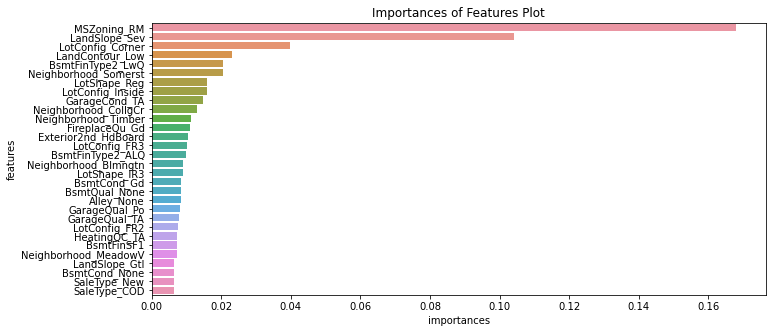

In [56]:
plot_feature_importance(full_cols, xgbrfr.feature_importances_, 30)


In [60]:
import time
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from xgboost import XGBRFRegressor
import xgboost as xgb

xgb.set_config(verbosity=0)
params = {
    'xgbrfregressor__n_estimators': [100, 250, 500],
    'xgbrfregressor__learning_rate': [1, .5, .1],
    'xgbrfregressor__min_child_weight': [3, 4, 5],
    'xgbrfregressor__gamma': [i/10.0 for i in range(4, 6)],
    'xgbrfregressor__subsample': [.6, .8, 1],
    'xgbrfregressor__colsample_bytree': [.6, .8, 1],
    'xgbrfregressor__max_depth': [2, 4, 6],
    'xgbrfregressor__objective': ['reg:squarederror'],
    'xgbrfregressor__booster': ['gbtree', "dart"],
    'xgbrfregressor__eval_metric': ['rmse'],
    'xgbrfregressor__eta': [i/10.0 for i in range(3, 6)],
}

n_samples = X_train.shape[0]
hrs_full_feats=HalvingRandomSearchCV(
    xgbrfr,
    resource='n_samples',
    n_candidates='exhaust',

    min_resources=80,
    max_resources=n_samples,
    param_distributions=params, 
    cv=5, 
    verbose=3, factor=1.05,
    random_state=888,
)

start = time.time()
hrs_full_feats.fit(X_train, y_train)
print(f"GridSearchCV took {(time.time() - start):%.2f} seconds parameter settings." % (()))


n_iterations: 50
n_required_iterations: 50
n_possible_iterations: 50
min_resources_: 80
max_resources_: 933
aggressive_elimination: False
factor: 1.05
----------
iter: 0
n_candidates: 11
n_resources: 80
Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END xgbrfregressor__booster=gbtree, xgbrfregressor__colsample_bytree=0.8, xgbrfregressor__eta=0.4, xgbrfregressor__eval_metric=rmse, xgbrfregressor__gamma=0.4, xgbrfregressor__learning_rate=1, xgbrfregressor__max_depth=2, xgbrfregressor__min_child_weight=3, xgbrfregressor__n_estimators=100, xgbrfregressor__objective=reg:squarederror, xgbrfregressor__subsample=1;, score=(train=0.974, test=0.820) total time=   0.6s
[CV 2/5] END xgbrfregressor__booster=gbtree, xgbrfregressor__colsample_bytree=0.8, xgbrfregressor__eta=0.4, xgbrfregressor__eval_metric=rmse, xgbrfregressor__gamma=0.4, xgbrfregressor__learning_rate=1, xgbrfregressor__max_depth=2, xgbrfregressor__min_child_weight=3, xgbrfregressor__n_estimators=100, xgbrfregr

In [ ]:
hrs_full_feats.estimator


In [ ]:
plot_validation_curves(hrs_full_feats.cv_results_, hrs_full_feats.param_distributions)
